# Local Interpretability

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#default_exp core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#exporti
from fastai.vision import *
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gif
import math
import numpy as np
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#exporti
def dice_by_component(predictedMask, trueMask, component = 1):
    dice = Tensor([1])
    pred = predictedMask.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        dice = 2 * intersect.sum().float() / total
    return dice.item()

## Sensitivity Analysis

### Example data (kaggle)

In [ ]:
#export
class Fastai1_model:
    def __init__(self, github, model):
        self.trainedModel = torch.hub.load(github,model)
        self.resize256 = lambda x: x.resize(256)
        
    def prepareSize(self, item):
        return self.resize256(item)
    
    def predict(self, image):
        return self.trainedModel.predict(image)

In [ ]:
#hide_output
img = lambda: open_image("example/kaggle/images/1-frame014-slice005.png")
trueMask = lambda: open_mask("example/kaggle/masks/1-frame014-slice005.png")
trainedModel = Fastai1_model('chfc-cmi/cmr-seg-tl', 'cmr_seg_base')

Using cache found in /home/ankenbrand/.cache/torch/hub/chfc-cmi_cmr-seg-tl_master


### Generic functions

In [ ]:
#export
def get_generic_series(image,
        model,
        transform,
        truth=None,
        tfm_y=False,
        start=0,
        end=180,
        step=30,
        log_steps=False,
    ):
    series = []
    trueMask = None
    steps = np.arange(start,end,step)
    if log_steps:
        steps = np.exp(np.linspace(log(start),log(end),int((end-start)/step)))
    for param in tqdm(steps, leave=False):
        img = image.clone()
        img = transform(img, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
        pred = model.predict(img)[0]
        series.append([param,img,pred])
        if truth:
            trueMask = truth.clone()
            if tfm_y:
                trueMask = transform(trueMask, param)
            if hasattr(model,"prepareSize"):
                trueMask = model.prepareSize(trueMask)
        series[-1].append(trueMask)
    return series

In [ ]:
#export
def plot_series(
        series,
        nrow=1,
        figsize=(16,6),
        param_name='param',
        overlay_truth=False,
        vmax=None,
        **kwargs
    ):
    fig, axs = plt.subplots(nrow,math.ceil(len(series)/nrow),figsize=figsize,**kwargs)
    for element, ax in zip(series, axs.flatten()):
        param,img,pred,truth = element
        img.show(ax=ax, title=f'{param_name}={param:.2f}')
        pred.show(ax=ax,vmax=vmax)
        if overlay_truth and truth:
            truth.show(ax=ax,alpha=.2)

In [ ]:
#export
@gif.frame
def plot_frame(param, img, pred, param_name="param",vmax=None,**kwargs):
    _,ax = plt.subplots(**kwargs)
    img.show(ax,title=f'{param_name}={param:.2f}')
    pred.show(ax, vmax=vmax)

In [ ]:
#export
def gif_series(series, fname, duration=150, param_name="param", vmax=None):
    frames = [plot_frame(*x[:3], param_name=param_name, vmax=vmax) for x in series]
    gif.save(frames, fname, duration=duration)

In [ ]:
#export
def eval_generic_series(
        image,
        mask,
        model,
        transform_function,
        start=0,
        end=360,
        step=5,
        param_name="param",
        mask_transform_function=None,
        components=['bg', 'c1','c2']
    ):
    results = list()
    for param in tqdm(np.arange(start, end, step), leave=False):
        img = image.clone()
        img = transform_function(img, param)
        trueMask = mask.clone()
        if mask_transform_function:
            trueMask = mask_transform_function(trueMask, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
            trueMask = model.prepareSize(trueMask)
        prediction = model.predict(img)[0]
        # prediction._px = prediction._px.float()
        result = [param]
        for i in range(len(components)):
            result.append(dice_by_component(prediction, trueMask, component = i))
        results.append(result)

    results = pd.DataFrame(results,columns = [param_name, *components])
    return results

### Rotation

In [ ]:
#export
def rotationTransform(image, deg):
    return image.rotate(int(deg))

def get_rotation_series(image, model, start=0, end=360, step=60, **kwargs):
    return get_generic_series(image,model,rotationTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_rotation_series(img(), trainedModel, truth=trueMask(), tfm_y=True)

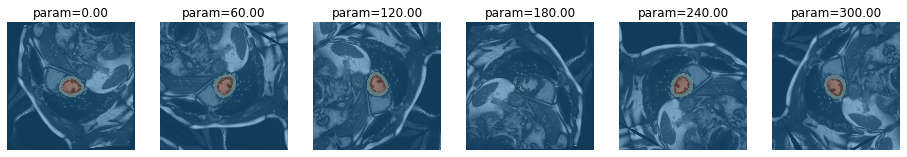

In [ ]:
plot_series(series)

In [ ]:
#export
def eval_rotation_series(image, mask, model, step=5, start=0, end=360, **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        rotationTransform,
        start=start,
        end=end,
        step=step,
        mask_transform_function=rotationTransform,
        param_name="deg",
        **kwargs
    )

Text(0, 0.5, 'dice')

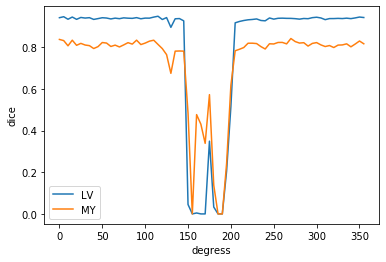

In [ ]:
results = eval_rotation_series(img(), trueMask(), trainedModel)
plt.plot(results['deg'], results['c1'], label='LV')
plt.plot(results['deg'], results['c2'], label='MY')
plt.legend()
plt.xlabel('degress')
plt.ylabel('dice')

You can easily generate gifs by plotting multiple frames

In [ ]:
gif_series(
    get_rotation_series(img(),trainedModel,start=0,end=360,step=5),
    "example/kaggle/rotation.gif",
    duration=150,
    param_name="degrees"
)

![segmentation sensitivity to rotation](example/kaggle/rotation.gif)

### Cropping

In [ ]:
#export
def cropTransform(image, pxls, finalSize=256):
    image = image.clone()
    image = image.resize(finalSize)
    image = image.crop_pad(int(pxls))
    image = image.rotate(180)
    image = image.crop_pad(finalSize, padding_mode="zeros")
    image = image.rotate(180)
    return image

def get_crop_series(image, model, start=56, end=257, step=50, finalSize=256, **kwargs):
    return get_generic_series(image,model,partial(cropTransform,finalSize=finalSize), start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_crop_series(img(), trainedModel, truth=trueMask(), tfm_y=True, step=20)

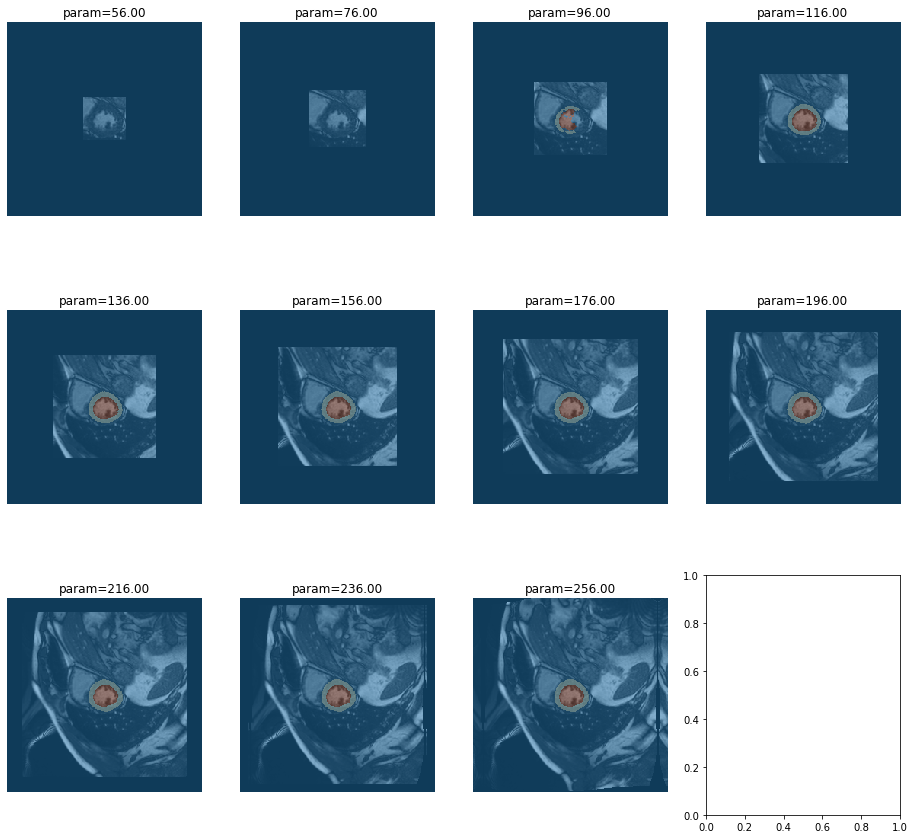

In [ ]:
plot_series(series,nrow=3,figsize=(16,15))#,overlay_truth=True)

In [ ]:
#export
def eval_crop_series(image, mask, model, step=5, start=56, end=256, **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        cropTransform,
        start=start,
        end=end,
        step=step,
        mask_transform_function=cropTransform,
        param_name="pixels",
        **kwargs
    )

Text(0, 0.5, 'dice')

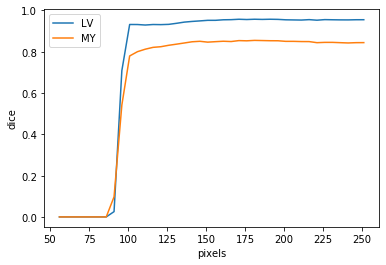

In [ ]:
results = eval_crop_series(img(), trueMask(), trainedModel)
plt.plot(results['pixels'], results['c1'], label='LV')
plt.plot(results['pixels'], results['c2'], label='MY')
plt.legend()
plt.xlabel('pixels')
plt.ylabel('dice')

Cropping and comparing to the full original mask might not be desired. In this case it is possible to crop the mask as well. All pixels in the cropped area are set to 0 (commonly the background class). As soon as a class is completely missing, the dice score might jump to 1 because not predicting the class is correct in that case.

In [ ]:
gif_series(
    get_crop_series(img(),trainedModel,start=256,end=16,step=-10),
    "example/kaggle/crop.gif",
    duration=150,
    param_name="pixels"
)

![segmentation sensitivity to cropping](example/kaggle/crop.gif)

### Brightness

In [ ]:
#export
def brightnessTransform(image, light):
    return image.brightness(light)

def get_brightness_series(image, model, start=0.05, end=1, step=.1, **kwargs):
    return get_generic_series(image,model,brightnessTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_brightness_series(img(), trainedModel, truth=trueMask())

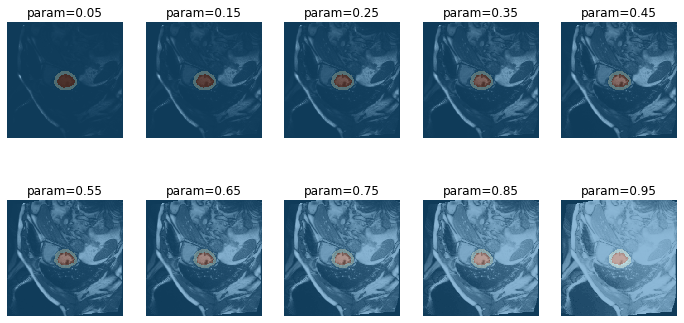

In [ ]:
plot_series(series, nrow=2, figsize=(12,6))

In [ ]:
#export
def eval_bright_series(image, mask, model, start=0.05, end=.95, step=0.05, param_name="brightness", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        brightnessTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

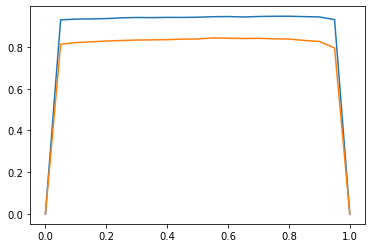

In [ ]:
results = eval_bright_series(img(), trueMask(), trainedModel, start=0, end=1.05)
plt.plot(results['brightness'], results['c1'])
plt.plot(results['brightness'], results['c2'])

In [ ]:
gif_series(
    get_brightness_series(img(), trainedModel,step=.05),
    "example/kaggle/brightness.gif",
    param_name="brightness"
)

![segmentation sensitivity to brightness](example/kaggle/brightness.gif)

### Contrast

In [ ]:
#export
def contrastTransform(image, scale):
    return image.contrast(scale)

def get_contrast_series(image, model, start=0.1, end=7.01, step=1, **kwargs):
    return get_generic_series(image,model,contrastTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_contrast_series(img(), trainedModel, truth=trueMask())

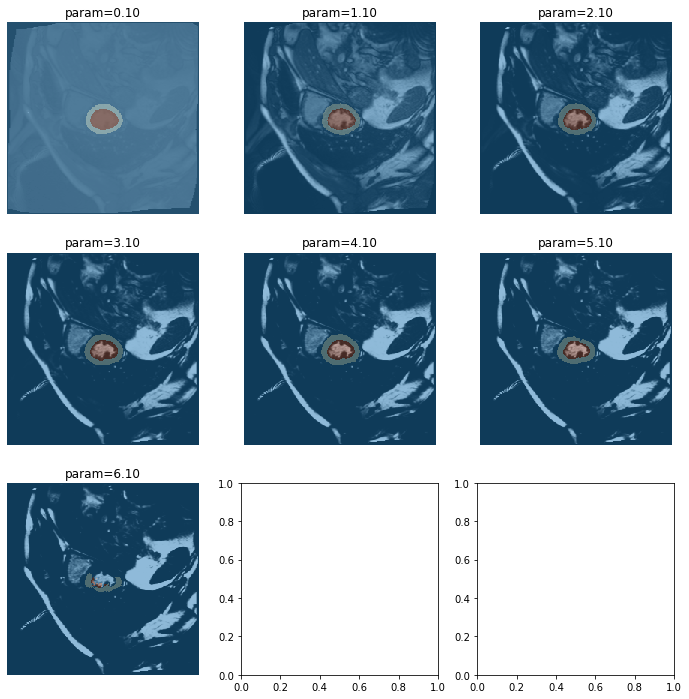

In [ ]:
plot_series(series, nrow=3, figsize=(12,12))

In [ ]:
#export
def eval_contrast_series(image, mask, model, start=0.1, end=7.1, step=0.5, param_name="contrast", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        contrastTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

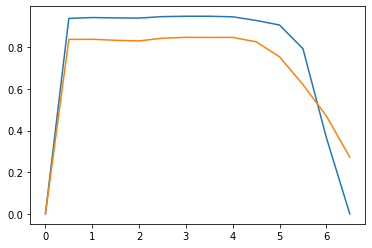

In [ ]:
results = eval_contrast_series(img(), trueMask(), trainedModel, start=0, end=7, step=0.5)
plt.plot(results['contrast'], results['c1'])
plt.plot(results['contrast'], results['c2'])

In [ ]:
gif_series(
    get_contrast_series(img(), trainedModel,step=.5),
    "example/kaggle/contrast.gif",
    param_name="contrast"
)

![segmentation sensitivity to contrast](example/kaggle/contrast.gif)

### Zoom

In [ ]:
#export
def zoomTransform(image, scale, finalSize=256):
    image = image.resize(256).clone()
    image = image.crop_pad(int(scale), padding_mode="zeros")
    image = image.resize(256).clone()
    return image

def get_zoom_series(image, model, start=56, end=500, step=50, **kwargs):
    return get_generic_series(image,model,zoomTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_zoom_series(img(), trainedModel, truth=trueMask())

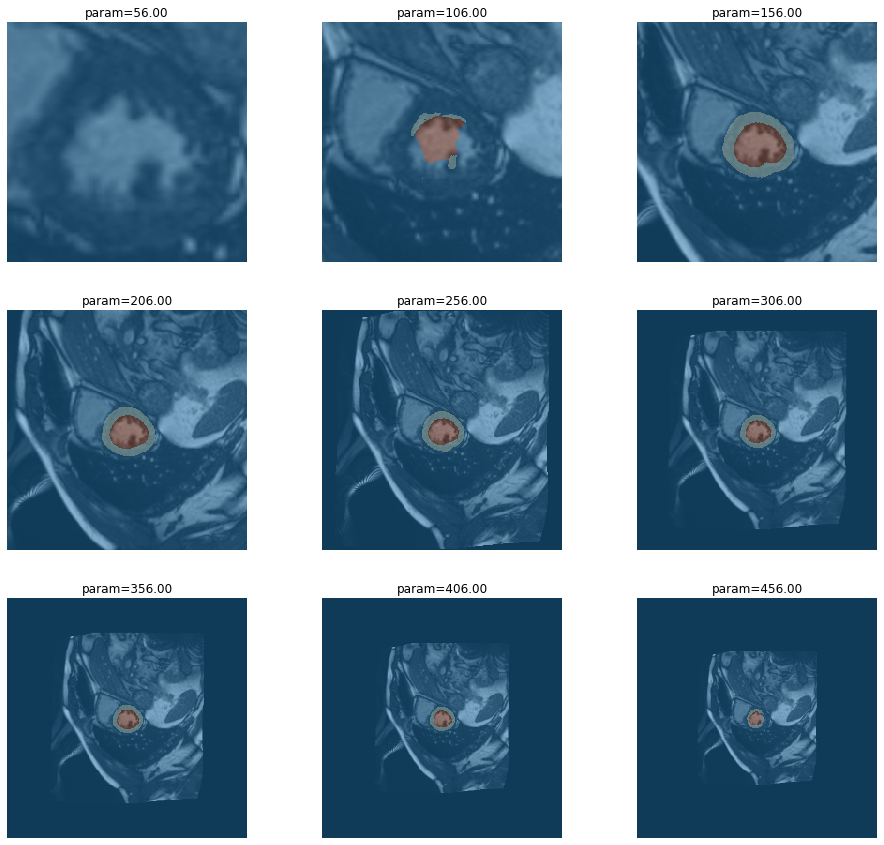

In [ ]:
plot_series(series, nrow=3, figsize=(16,15))

In [ ]:
#export
def eval_zoom_series(image, mask, model, step=10, start=56, end=500, **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        zoomTransform,
        start=start,
        end=end,
        step=step,
        mask_transform_function=zoomTransform,
        param_name="scale",
        **kwargs
    )

Text(0, 0.5, 'dice')

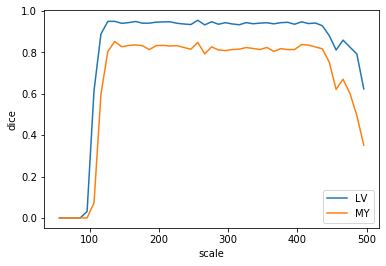

In [ ]:
results = eval_zoom_series(img(), trueMask(), trainedModel)
plt.plot(results['scale'], results['c1'], label='LV')
plt.plot(results['scale'], results['c2'], label='MY')
plt.legend()
plt.xlabel('scale')
plt.ylabel('dice')

In [ ]:
gif_series(
    get_zoom_series(img(),trainedModel,start=500,end=16,step=-10),
    "example/kaggle/zoom.gif",
    duration=250,
    param_name="scale"
)

![segmentation sensitivity to zoom](example/kaggle/zoom.gif)

### Dihedral

In [ ]:
#export
def dihedralTransform(image, sym_im):
    return image.dihedral(k=int(sym_im))

def get_dihedral_series(image, model, start=0, end=8, step=1, **kwargs):
    return get_generic_series(image,model,dihedralTransform, start=start, end=end, step=step, **kwargs)

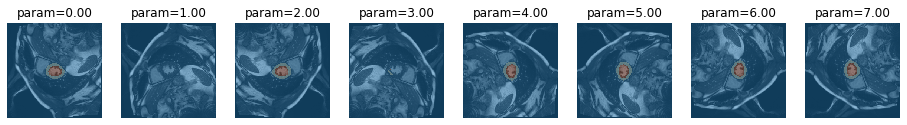

In [ ]:
plot_series(get_dihedral_series(img(), trainedModel))

In [ ]:
#export
def eval_dihedral_series(image, mask, model, start=0, end=8, step=1, param_name="k", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        dihedralTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=dihedralTransform,
        **kwargs
    )

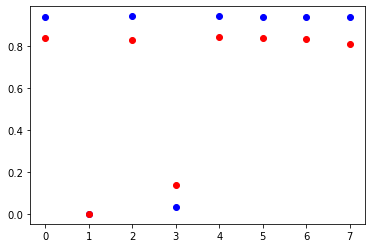

In [ ]:
results = eval_dihedral_series(img(), trueMask(), trainedModel)
plt.plot(results['k'], results['c1'], 'bo')
plt.plot(results['k'], results['c2'], 'ro')

In [ ]:
gif_series(
    get_dihedral_series(img(), trainedModel),
    "example/kaggle/dihedral.gif",
    param_name="k",
    duration=1000
)

![segmentation sensitivity to dihedral](example/kaggle/dihedral.gif)

### Resize

In [ ]:
#export
def resizeTransform(image, size):
    return image.resize(int(size)).clone()

In [ ]:
#export
def get_resize_series(image, model, start=10, end=200, step=30, **kwargs):
    return get_generic_series(image,model,resizeTransform, start=start, end=end, step=step, **kwargs)

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


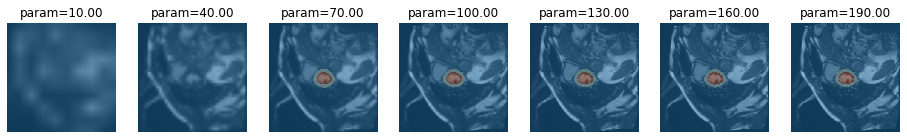

In [ ]:
plot_series(get_resize_series(img(), trainedModel), sharex=True, sharey=True)

In [ ]:
#export
def eval_resize_series(image, mask, model, start=22, end=3000, step=100, param_name="px", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        resizeTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=resizeTransform,
        **kwargs
    )

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


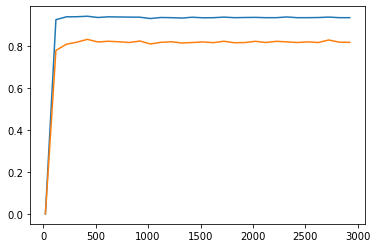

In [ ]:
results = eval_resize_series(img(), trueMask(), trainedModel)
plt.plot(results['px'], results['c1'])
plt.plot(results['px'], results['c2'])

In [ ]:
gif_series(
    get_resize_series(img(), trainedModel),
    "example/kaggle/resize.gif",
    param_name="k",
    duration=200
)

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
